##Simulating sky images, with source noise
###Simpliest as possible
####Written by Sergio Hernandez Charpak
####13/06/2016

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import cv2
from astropy.io import fits
#Running bash
import subprocess

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Function to make the histogram of an image given the number of bins and the image
def make_histogram(image, bins, title):
    hist, bins = np.histogram(image.ravel(),bins=bins)
    n_bins = np.zeros(len(hist))
    for i in range(len(hist)):
        n_bins[i] = (bins[i]+bins[i+1])/2.0
    fig = plt.figure(figsize = (8,8))
    plt.step( n_bins,hist,linewidth=3 )
    plt.xlabel("Gray scale level", fontsize=20)
    plt.ylabel("Number of pixels", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.title(title, fontsize=20)
    #Uncomment to save as png
    #plt.savefig("path_images+'histogram_new.png",format = "png")

In [3]:
path_images = './Images/withNoise/'

####Note
This code produce an error if the images already exist. 

In [4]:
comando = 'rm '+path_images+'*.fits'
process =subprocess.Popen(comando,stdout=subprocess.PIPE, stderr=None, shell=True)
resultsString=process.communicate()
print resultsString

('', None)


<p>We want to simulate:</p>
<ul>
<li>Sky Flux</li>
<li>Delta sources</li>
<li>Background noise</li>
<li>Source noise</li>
</ul>
Our two outputs are going to be pairs of New/Reference:
<ul>
<li>Sky substracted Image</li>
<li>Image with the background</li>
</ul>

###Theory Images

In [5]:
width = 255
height = 255
#Black image
#black_image = np.zeros((height,width), np.uint8)
black_image = np.zeros((height,width))
fits.PrimaryHDU(black_image).writeto(path_images+'blackImage.fits')
#scipy.misc.toimage(black_image, cmin=np.min(black_image), cmax=np.max(black_image)).save(path_images+'blackImage.jpg')
#cv2.imwrite(path_images+'blackImage.jpg', black_image)

In [6]:
#Sky flux
sky_flux = 600
sky_image = black_image + sky_flux
fits.PrimaryHDU(sky_image).writeto(path_images+'sky_image.fits')
#scipy.misc.toimage(sky_image, cmin=np.min(sky_image), cmax=np.max(sky_image)).save(path_images+'skyImage.jpg')
#cv2.imwrite(path_images+'skyImage.jpg', sky_image)

In [7]:
#Reference Image
reference = black_image.copy()

In [8]:
#Some delta sources
cv2.circle(reference, (width/2,height/2), 1, (255, 255, 255), -1) 
cv2.circle(reference, (width/3, height/4), 1, (5000, 5000, 5000), -1)
cv2.ellipse(reference,(int(width*0.8), int(height*0.4)),(20,40),30,0,360,100,-1)
reference = reference + sky_image.copy()

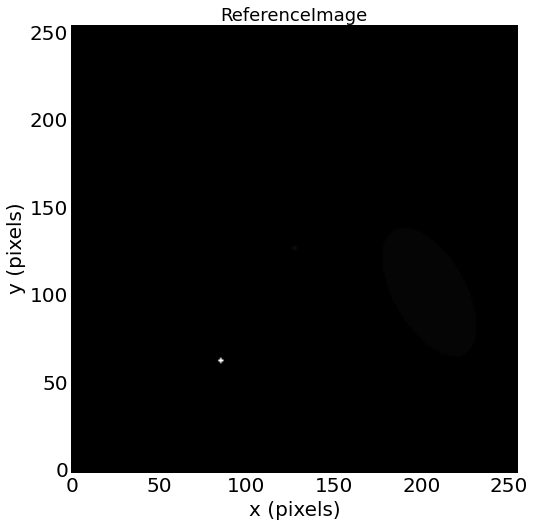

In [9]:
fig = plt.figure(figsize = (8,8))
plt.imshow(reference, cmap = 'gray', origin='lower')
plt.title('ReferenceImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [10]:
#New Image
new_image = reference.copy()

In [11]:
#Some delta sources
cv2.circle(new_image, (64, 180), 1, (reference[180, 64] + 255, reference[180, 64]+ 255, reference[180, 64] + 255), -1) # an asteroid !!
cv2.circle(new_image, (210, 120), 1, (reference[120, 210] + 255, reference[120, 210] + 255, reference[120, 210] + 255), -1) # a supernova !!! 

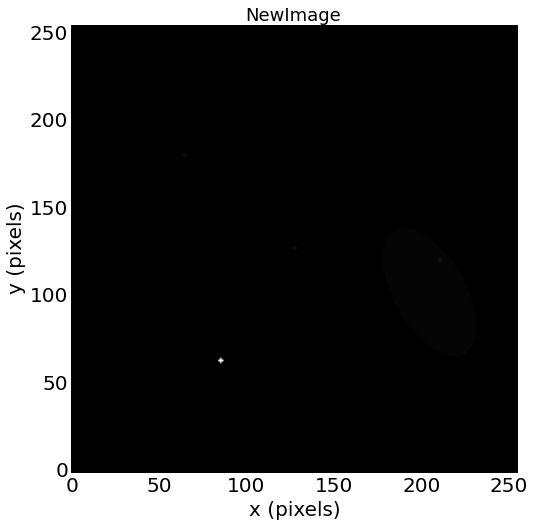

In [12]:
fig = plt.figure(figsize = (8,8))
plt.imshow(new_image, cmap = 'gray', origin='lower')
plt.title('NewImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [13]:
#These are the theory images
#Fits to preserve the values. Other formats have limitation (ex: 255 greyscale level)
fits.PrimaryHDU(reference).writeto(path_images+'truesky_ref.fits')
fits.PrimaryHDU(new_image).writeto(path_images+'truesky_new.fits')

#scipy.misc.toimage(reference, cmin=np.min(reference), cmax=np.max(reference)).save(path_images+'truesky_ref.jpg')
#scipy.misc.toimage(new_image, cmin=np.min(new_image), cmax=np.max(new_image)).save(path_images+'truesky_new.jpg')
#cv2.imwrite(path_images+'truesky_ref.jpg', reference)
#cv2.imwrite(path_images+'truesky_new.jpg', new_image)

In [14]:
#PSF
reference = cv2.GaussianBlur(reference, (3,3), 3, 3)
new_image = cv2.GaussianBlur(new_image, (3,3), 3, 3)

###Measured Images

In [15]:
#The background noise is no longer calculated from one point.
#It is calculated locally for each pixel value.
row, col = sky_image.shape
mean = 0
for i in range(row):
    for j in range(col):
        noise_ref = np.random.normal(mean, np.sqrt(reference[i,j]), (1))
        noise_new = np.random.normal(mean, np.sqrt(new_image[i,j]), (1))
        reference[i,j] = reference[i,j] + noise_ref
        new_image[i,j] = new_image[i,j] + noise_new
#print np.mean(np.sqrt(reference)), np.mean(np.sqrt(new_image))

In [16]:
print np.std(reference), np.std(new_image)

40.3336975657 40.7337479646


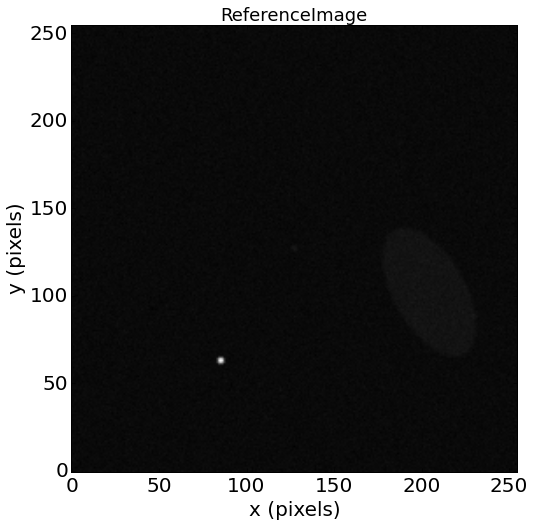

In [17]:
fig = plt.figure(figsize = (8,8))
plt.imshow(reference, cmap = 'gray', origin='lower')
plt.title('ReferenceImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

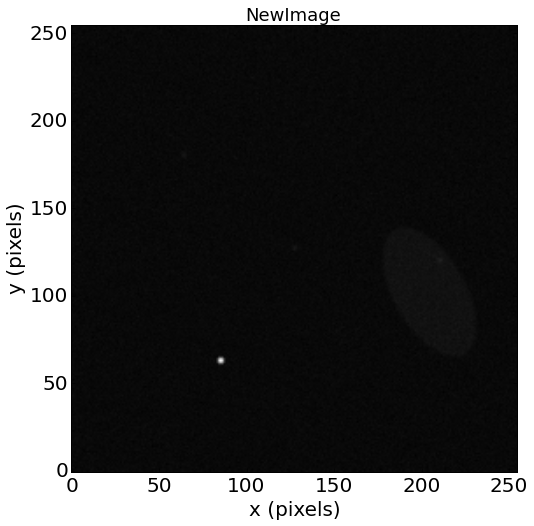

In [18]:
fig = plt.figure(figsize = (8,8))
plt.imshow(new_image, cmap = 'gray', origin='lower')
plt.title('NewImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [19]:
#These are the measured images with background
fits.PrimaryHDU(reference).writeto(path_images+'ReferenceImage_b.fits')
fits.PrimaryHDU(new_image).writeto(path_images+'NewImage_b.fits')
#scipy.misc.toimage(reference, cmin=np.min(reference), cmax=np.max(reference)).save(path_images+'ReferenceImage_b.jpg')
#scipy.misc.toimage(new_image, cmin=np.min(new_image), cmax=np.max(new_image)).save(path_images+'NewImage_b.jpg')
#cv2.imwrite(path_images+'NewImage_b.jpg', new_image)
#cv2.imwrite(path_images+'ReferenceImage_b.jpg', reference)

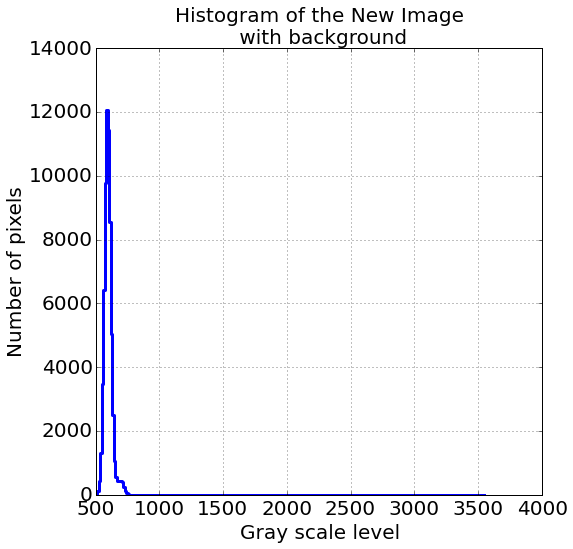

In [20]:
make_histogram(new_image,255, "Histogram of the New Image \n with background")

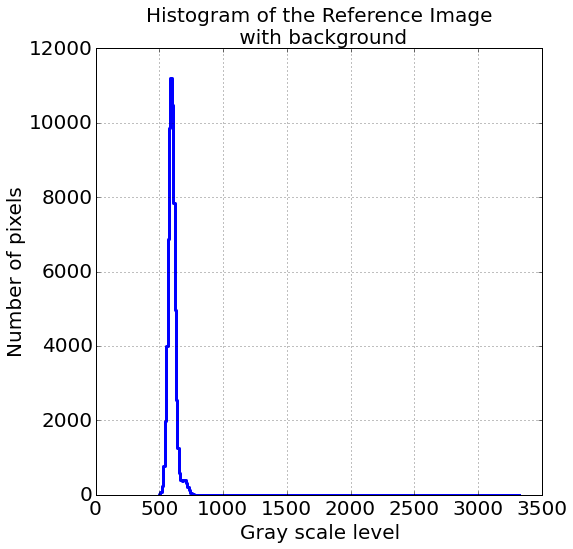

In [21]:
make_histogram(reference,255,"Histogram of the Reference Image \n with background")

In [22]:
#We substract the sky to get the final results
reference = (reference - sky_image.copy())
new_image = (new_image - sky_image.copy())

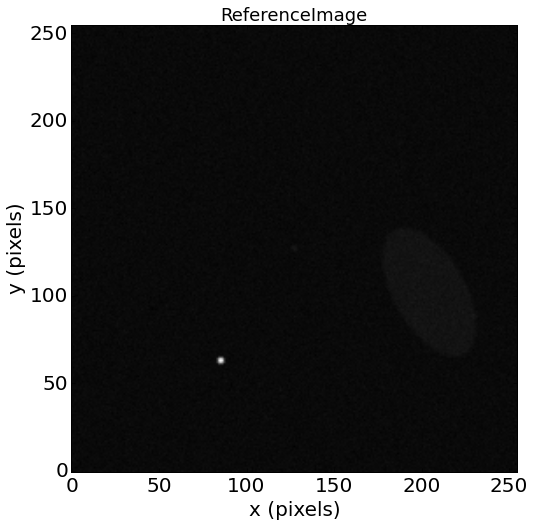

In [23]:
fig = plt.figure(figsize = (8,8))
plt.imshow(reference, cmap = 'gray', origin='lower')
plt.title('ReferenceImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

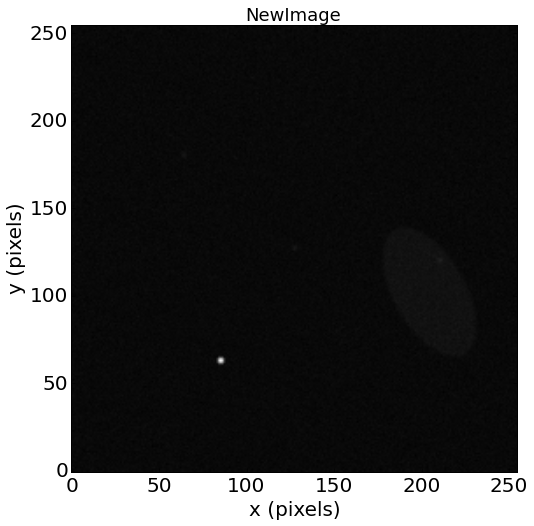

In [24]:
fig = plt.figure(figsize = (8,8))
plt.imshow(new_image, cmap = 'gray', origin='lower')
plt.title('NewImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [25]:
fits.PrimaryHDU(reference).writeto(path_images+'ReferenceImage.fits')
fits.PrimaryHDU(new_image).writeto(path_images+'NewImage.fits')
#scipy.misc.toimage(reference, cmin=np.min(reference), cmax=np.max(reference)).save(path_images+'ReferenceImage.jpg')
#scipy.misc.toimage(new_image, cmin=np.min(new_image), cmax=np.max(new_image)).save(path_images+'NewImage.jpg')
#cv2.imwrite(path_images+'NewImage.jpg', new_image)
#cv2.imwrite(path_images+'ReferenceImage.jpg', reference)

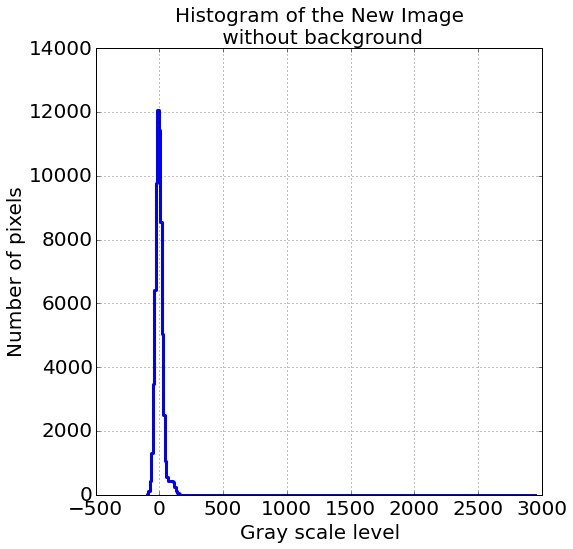

In [26]:
make_histogram(new_image,255,"Histogram of the New Image \n without background")

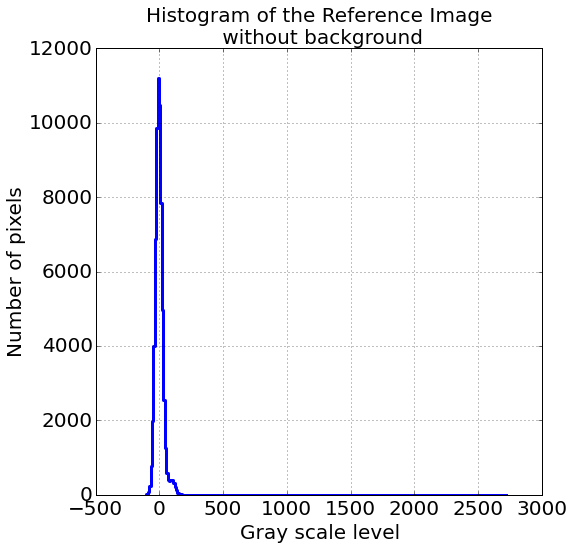

In [27]:
make_histogram(reference,255, "Histogram of the Reference Image \n without background")